<a href="https://colab.research.google.com/github/DougAugSilva/Treinando-uma-Rede-Neural-GAN-em-Python/blob/main/GUN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN's - Generative Adversarial Networks

## Teoria

### Definição

GAN's são um tipo de modelo de machine learnig composto por duas redes neurais: o Gerador (G) eo Discriminador (D).

- **Objetivo de G:** O Gerador cira dados (como imagens, textos e etc) que tentam imitar os dados de treinamento.

- **Objetivo de D:** Já o Discriminador tem a tarefa de distinguir qusi são os dados de reais e quais são os dados gerados pelo gerador G.


### Função de Perda
Na realização do treinamento, asim como em qualquer modelo de aprendizado de maquina supervisionado, precisamos de uma função de perda (*loss function*), sendo que esta é diferente para G e D.

- Função loss da rede Geradora (G)

|               | Loss                |
| ------------- | ------------------- |
| Valores Altos | Não está enganado D |
| Valores Baxos | Está enganando D    |  

- Função loss da rede Discriminadora (D)

|               | Loss                    |
| ------------- | ----------------------- |
| Valores Altos | Não consegue distinguir |
| Valores Baxos | Consegue distinguir     |  

No processo de treinamento, buscamos um equilibrio entre as *loss functions* de G e de D. O Discrimiador é utilizado apenas no processo de treinamento, podendo ser descartado posteriormente, pois o que nos interessa é apenas a rede Geradora G.

### Espaço Latente

O espaço latente é outro hiperparametro que a parece em redes neurais, depois que os dados entram na rede neural, o espaço latente é responsavel poir fazer uma redução na dimensão destes dados, visando assim um a maior eficinecia computacional. Temos algumas vantagens e desvantagens quanto a dimensionalidade do espaço latente, sendo estas:

- **Espaço Latente de Alta Dimensão:** A complexidade da rede neural se torna grande, podendop ser inificeinte computacionalmente e gerar super ajuste (overfitting).

- **Espaço Latente de Baixa Dimensão:** Pode ocorrer muita perda de informação na etapa de passagens dos dados de treinamento pelo espaço latente, com isso pode haver uma perda de variabilidade nos dados gerados pela rede neural. Temos também um menor risco de super ajuste.


## Aplicação

Vamos realizar o treinamento de uma GUN em Python, para tal será utilizado o conjunto de dados MNIST para o treinamento. O conjunrto MNIST é formado por algarismos escritos a mão de 0 a 9 com resolução de 28x28 pixels. Também serão utilizadas aas segintes bibliotecas:

- Pytorch
- Matplotlib
- Numpy
- Random

### Importando Dados e Bibliotecas

In [2]:
# Se executar no Colab, Lembre-se de habilitar a GPU

import torch
import torch.nn as nn  # permite criar uma classe para as redes neurais G e D
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt  # exibir imagens
import numpy as np
import random

In [3]:
# importando o conjunto de dados MNIST
mnist_data = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 495kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.53MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.86MB/s]


Importando o conjunto de dados MNIST, vamos extrair 9 amostras aleatórias de dados deste para a visualização. Isso é feito pelo código abaixo.

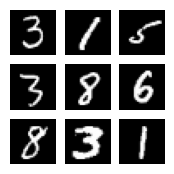

In [4]:
# Visualizando uma amostra de 9 elementos do MNIST
indices = random.sample(range(100), 9)
images = [mnist_data[i][0] for i in indices]

fig, axes = plt.subplots(3, 3, figsize=(2, 2))

for i, ax in enumerate(axes.flat):
  ax.imshow(images[i].squeeze().numpy(), cmap='gray')
  ax.axis('off')

plt.show()

### Criando a GUN

Configurando agora alguns Hiper parametros de redes neuraurais, como batch size, número de epochs e etc.

In [5]:
# Hiper parametros
batch_size = 128
latent_dim = 100
lr = 0.0002
epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Realizando a conversão das imagens *.pil* para tensores do *PyTorch*, bem como escalar os valores dos pixels para o intervalo [0, 1] e realizar a normalização dos tensores para uma média de 0,5 e desvio padrão de 0,5.

Posteriormente vamos salvar o conjunto de dados MNISt no diretório `./data`. O suffle é aplicado para embaralhar os dados de entrada, melhorando assim a genrealização do modelo, pois uma ordenação dos dados poderia inserir um viés.

In [6]:
# pré-processamento dos dados para o treinamento
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

dataloader = torch.utils.data.DataLoader(datasets.MNIST('./data', train=True,
                                                        download=True, transform=transform), batch_size=batch_size, shuffle=True)

Agora podemos criar as redes neurais Geradoras G e discriminadoras D.

As redes neurais Geradora e Discriminadora serão do tipo totalmente conectada (multi layer perceptron), para isso vamos utilizar uma classe do PyrTorch para ir empilhando as camadas da rede neural com `nn.Sequential`.

In [7]:
# Criando Gerador
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.model = nn.Sequential(
        nn.Linear(latent_dim, 256),      # Primeira camada de entrada com latent_dim para 256 neurónios
        nn.LeakyReLU(0.2, inplace=True), # Utlizando a função de ativação LeakyReLU
        nn.Linear(256, 512),             # Segunda camada com 256 para 512 neurónios
        nn.LeakyReLU(0.2, inplace=True), # Utlizando a função de ativação LeakyReLU
        nn.Linear(512, 1024),            # Terceira camada com 512 para 1024 neurónios
        nn.LeakyReLU(0.2, inplace=True), # Utlizando a função de ativação LeakyReLU
        nn.Linear(1024, 28*28),          # Camadada e saida com 1024 para 28*28 neurónios
        nn.Tanh()                        # Função de ativação que escala os valores dos pixels para o intervalo [0, 1]
    )
  def forward(self, z):                   # Função de passagem dos dados pela a rede neural
    return self.model(z).view(z.size(0), 1, 28, 28)

In [8]:
# Criando o Discriminador
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.model = nn.Sequential(
        nn.Linear(28*28, 1024),           # Primeira camada de entrada com 28*28 para 1024 neurónios
        nn.LeakyReLU(0.2, inplace=True),  # Utlizando a função de ativação LeakyReLU
        nn.Dropout(0.3),                  # Utlizando a função Dropout
        nn.Linear(1024, 512),             # Segunda camada com 1024 para 512 neurónios
        nn.LeakyReLU(0.2, inplace=True),  # Utlizando a função de ativação LeakyReLU
        nn.Dropout(0.3),                  # Utlizando a função Dropout
        nn.Linear(512, 256),              # Terceira camada com 512 para 256 neurónios
        nn.LeakyReLU(0.2, inplace=True),  # Utlizando a função de ativação LeakyReLU
        nn.Dropout(0.3),                  # Utlizando a função Dropout
        nn.Linear(256, 1),                # Camadada e saida com 256 para 1 neurónio
        nn.Sigmoid()                      # Função de ativação que escala os valores dos pixels segundo um sigmoid
    )
  def forward(self, img):                 # Função de passagem dos dados pela a rede neural
    img_flat = img.view(img.size(0), -1)
    return self.model(img_flat)

In [9]:
# Criando instancias das classse definidas, o to(device) é para chamar a GPU
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [10]:
# Definindo Otimizadores
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Definindo função de perda (loss function) binary cross entropy
criterion = nn.BCELoss()

### Treinamento da GUN

Alem do treinamento, vamos acompamhar a função loss de D e G respectivamente, visualizando a média da loss a cada 10 Epochs.

[Epoch 10/100] [Média da loss de D: 0.466] [Média da loss de G: 1.592]


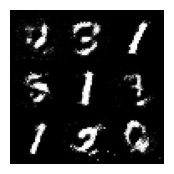

[Epoch 20/100] [Média da loss de D: 0.509] [Média da loss de G: 1.369]


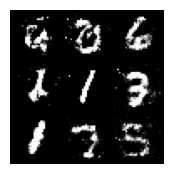

[Epoch 30/100] [Média da loss de D: 0.544] [Média da loss de G: 1.242]


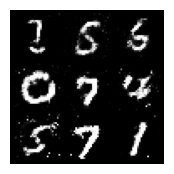

[Epoch 40/100] [Média da loss de D: 0.573] [Média da loss de G: 1.128]


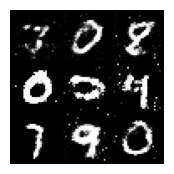

[Epoch 50/100] [Média da loss de D: 0.591] [Média da loss de G: 1.065]


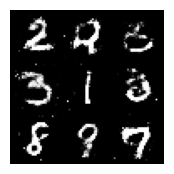

[Epoch 60/100] [Média da loss de D: 0.593] [Média da loss de G: 1.056]


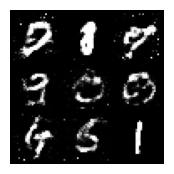

[Epoch 70/100] [Média da loss de D: 0.611] [Média da loss de G: 0.992]


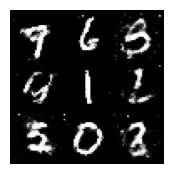

[Epoch 80/100] [Média da loss de D: 0.617] [Média da loss de G: 0.968]


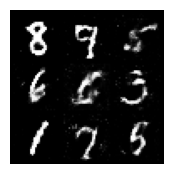

[Epoch 90/100] [Média da loss de D: 0.617] [Média da loss de G: 0.971]


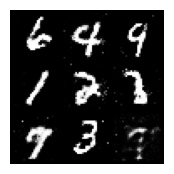

[Epoch 100/100] [Média da loss de D: 0.624] [Média da loss de G: 0.947]


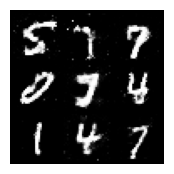

In [12]:
# Treinamentos, percorrimento das epocs
for epoch in range(epochs):
  d_loss_accumulated = 0.0  # Variavel que acumula a loss de D
  g_loss_accumulated = 0.0  # Variavel que acumula a loss de G

  for i, (imgs, _) in enumerate(dataloader):
    real = torch.ones(imgs.size(0), 1).to(device)   # Criando tensores com saidas 1 (True)
    fake = torch.zeros(imgs.size(0), 1).to(device)

    # Treinamento do Discriminador
    optimizer_D.zero_grad()                 # Começando com o gradiente igual a zero
    real_imgs = imgs.to(device)             # Passam as imagens do lote atrual ela CPU eou GPU
    pred_real = discriminator(real_imgs)    # Passam as imagens reais pelo discriminador
    loss_real = criterion(pred_real, real)  # Calcula a perda entre as previsões das imagens reais

    z = torch.randn(imgs.size(0), latent_dim).to(device)  # Gera um tensor aleatório para cada imagem do lote atual
    fake_imgs = generator(z)                               # Move op tensor aleatório para o dispositivo de treinamento
    pred_fake = discriminator(fake_imgs.detach())          # Passagem das imagens falsas pelo discriminador (calcula o gradiente)
    loss_fake = criterion(pred_fake, fake)                 # Calcula a perda entre as previsões das imagens falsas

    d_loss = (loss_real + loss_fake) / 2  # Média da loss das imagens reais e falsas
    d_loss.backward()                     # Retro Propagação (atualização dos pesos)
    optimizer_D.step()                    # Atualiza os parâmetros do Discriminador utlizando o otimizador Adam

    d_loss_accumulated += d_loss.item()   # Acumula a perda do Discriminador

    # Treinamento do Gerador
    optimizer_G.zero_grad()               # Gera o gradiente
    pred_fake = discriminator(fake_imgs)  # Passa as imagens falsas pelo discriminador para obtermos previsões
    g_loss = criterion(pred_fake, real)  # Calcumalos a perda do Gerador utilizando as previsões feitas pelo Discriminador para s imagens falsas
    g_loss.backward()                     # Retro Propagação (atualização dos pesos)
    optimizer_G.step()                    # Atualiza os parâmetros do gerador utlizandop o otimizador Adam

    g_loss_accumulated += g_loss.item()    # Acumula a perda do Gerador

    # Caso esteja no último batch da epoch e se temos que a epoch é um múltiplo de 10, imprimimos o feedback das loss e as imagens
    if i == len(dataloader) - 1 and (epoch + 1) % 10 == 0:
      d_loss_avg = d_loss_accumulated / len(dataloader)  # calcula a média da loss de D
      g_loss_avg = g_loss_accumulated / len(dataloader)  # calcula a média da loss de G

      print(f"[Epoch {epoch + 1 }/{epochs}] [Média da loss de D: {round(d_loss_avg, 3)}] [Média da loss de G: {round(g_loss_avg, 3)}]")  #Imprime as médias das loss de D e G

      # Gera 9 imagens geradas pelo geradopr G a cada 10 epochs
      grid = torchvision.utils.make_grid(fake_imgs.data[:9], nrow=3, normalize=True)
      grid_numpy = grid.permute(1, 2, 0).cpu().numpy()

      plt.figure(figsize=(2, 2))
      plt.imshow(grid_numpy)
      plt.axis('off')
      plt.show()